In [25]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import glob
import tqdm

### Prepare Data

In [26]:
folder_path = '/Users/xuzhaozhong/Downloads/jets'
x_train = []
y_train = []

for i in tqdm.trange(30000):
    formatted_i = "{:07}".format(i)
    file_path = f"{folder_path}/event_{formatted_i}.npz"  # Adjust the file extension if needed
    with np.load(file_path) as event:
        x_train.append(event['x'])
        y_train.append(event['y'])

100%|███████████████████████████████████| 30000/30000 [00:18<00:00, 1592.77it/s]


In [27]:
#Pad each jet by sequentially copying the first row to the last row and repeating the process until 100 rows have been reached
x_train_padded = []

for i in tqdm.trange(len(x_train)):
    padded_item = np.zeros((100, 5))
    num_rows = x_train[i].shape[0]
    repeat_factor = 100 // num_rows
    remaining_rows = 100 % num_rows
    
    # Repeat the original item 'repeat_factor' times
    for j in range(repeat_factor):
        padded_item[j*num_rows:(j+1)*num_rows, :] = x_train[i]

    # Copy the remaining rows
    if remaining_rows > 0:
        padded_item[repeat_factor*num_rows:repeat_factor*num_rows + remaining_rows, :] = x_train[i][:remaining_rows]

    x_train_padded.append(padded_item)

x_train_padded_array = np.array(x_train_padded)


100%|█████████████████████████████████| 30000/30000 [00:00<00:00, 375600.34it/s]


In [28]:
x_train = x_train_padded_array
y_train = np.array(y_train)

In [29]:
x_train = x_train.reshape(-1,100*5)
print(x_train.shape)

(30000, 500)


In [30]:
# Scale the dataset according to standard scaling
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)

In [31]:
x_test = x_train[25000:len(x_train)]
y_test = y_train[25000:len(x_train)]
x_validation=x_train[20000:25000]
y_validation=y_train[20000:25000]
x_train = x_train[:20000]
y_train = y_train[:20000]
print(x_train.shape,y_train.shape,x_test.shape)

(20000, 500) (20000, 5) (5000, 500)


### Define Model

In [32]:
class DnnClassification(torch.nn.Module):
    
    def __init__(self, input_dim, hidden_dim1, hidden_dim2 ,hidden_dim3,hidden_dim4, output_dim): # Feel free to add hidden_dim as parameters here
        
        super(DnnClassification, self).__init__()
        
        self.layer1=torch.nn.Linear(input_dim,hidden_dim1)
        self.layer2=torch.nn.Linear(hidden_dim1,hidden_dim2)
        self.layer3=torch.nn.Linear(hidden_dim2,hidden_dim3)
        self.layer4=torch.nn.Linear(hidden_dim3,hidden_dim4)
        self.layer5=torch.nn.Linear(hidden_dim4,output_dim)
        self.dropout=torch.nn.Dropout(p=0.5)
    def forward(self, x):
        
        out = torch.nn.functional.relu(self.layer1(x)) 
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.layer2(out))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.layer3(out))
        out = self.dropout(out)
        out = torch.nn.functional.relu(self.layer4(out))
        out = self.dropout(out)
        out = self.layer5(out)
        out = torch.softmax(out, dim=1)
        return out

### Define Hyperparameters

In [33]:
# Initialize our neural network model with input and output dimensions
model = DnnClassification(input_dim = 500, output_dim = 5, hidden_dim1 = 4096, hidden_dim2 = 4096,hidden_dim3 = 4096,hidden_dim4 = 4096)
device = torch.device( "mps"if torch.backends.mps.is_available else"cpu")
# Define the learning rate and epoch 
learning_rate = 0.0015
epochs = 100
batchsize = 4000#(If you are using mini-batch gradient)

# Define loss function and optimizer
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate,weight_decay=0.01)
model.to(device)

DnnClassification(
  (layer1): Linear(in_features=500, out_features=4096, bias=True)
  (layer2): Linear(in_features=4096, out_features=4096, bias=True)
  (layer3): Linear(in_features=4096, out_features=4096, bias=True)
  (layer4): Linear(in_features=4096, out_features=4096, bias=True)
  (layer5): Linear(in_features=4096, out_features=5, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

### Identify Tracked Values

In [34]:
validation_accuracy_list = []
train_loss_list = []

### Train Model

In [35]:
import tqdm # For keeping track of our training progress in percentage

# Convert the training, validation, testing dataset (NumPy arrays) into torch tensors

train_inputs = torch.from_numpy(x_train).float().to(device)
train_targets = torch.from_numpy(y_train).long().to(device) # Convert to 64-bit integer
x_batch_train = torch.split(train_inputs, batchsize)
y_batch_train = torch.split(train_targets, batchsize)
batch_split_num = len(x_batch_train)

validation_inputs = torch.from_numpy(x_validation).float().to(device)
validation_targets = torch.from_numpy(y_validation).long().to(device)

testing_inputs = torch.from_numpy(x_test).float().to(device)
testing_targets = torch.from_numpy(y_test).long().to(device)

# Training Loop ---------------------------------------------------------------------------------------

iteration = 0
for epoch in range(epochs):  
    for i in range(batch_split_num):
        optimizer.zero_grad() # Empty the gradient buffer so each learning event per epoch is separate

        outputs = model(x_batch_train[i]) # Forward pass the inputs through the network to produce outputs 
        
        y_batch_indices = torch.argmax(y_batch_train[i], dim=1)

        loss = loss_func(outputs, y_batch_indices) # Compute the loss via comparing the output with expected targets
    
        train_loss_list.append(loss.item()) # Save the loss value to train_loss_list we defined
    
        loss.backward() # Compute how much changes to be made to weights/biases

        optimizer.step() # Update the weights/biases according to learning rate
        
        outputs = model(validation_inputs)
        
        _, predicted = torch.max(outputs, 1)# Find the index  with the highest probability for each sample
        
        correct = (predicted == torch.argmax(validation_targets, dim=1)).sum().item()
        
        total = validation_targets.size(0)
        
        accuracy = correct / total
        
        validation_accuracy_list.append(accuracy)  

    print("Averaged Training Loss for Epoch ", epoch,": ", np.mean(train_loss_list[-batch_split_num:]))



Averaged Training Loss for Epoch  0 :  1.6001798391342164
Averaged Training Loss for Epoch  1 :  1.5786407947540284
Averaged Training Loss for Epoch  2 :  1.5055526494979858
Averaged Training Loss for Epoch  3 :  1.4705716609954833
Averaged Training Loss for Epoch  4 :  1.4587130784988402
Averaged Training Loss for Epoch  5 :  1.4530029058456422
Averaged Training Loss for Epoch  6 :  1.4499403238296509
Averaged Training Loss for Epoch  7 :  1.44690899848938
Averaged Training Loss for Epoch  8 :  1.4423058032989502
Averaged Training Loss for Epoch  9 :  1.435752844810486
Averaged Training Loss for Epoch  10 :  1.4251264095306397
Averaged Training Loss for Epoch  11 :  1.41172513961792
Averaged Training Loss for Epoch  12 :  1.3949040174484253
Averaged Training Loss for Epoch  13 :  1.3774001836776733
Averaged Training Loss for Epoch  14 :  1.3826246738433838
Averaged Training Loss for Epoch  15 :  1.3844324827194214
Averaged Training Loss for Epoch  16 :  1.379936122894287
Averaged Trai

In [36]:
with torch.no_grad():
    outputs = model(validation_inputs)
    _, predicted = torch.max(outputs, 1)# Find the index  with the highest probability for each sample
    correct = (predicted == torch.argmax(validation_targets, dim=1)).sum().item()
    total = validation_targets.size(0)
    accuracy = correct / total
    print('Accuracy: {:.2f}'.format(accuracy))

Accuracy: 0.66


### Visualize and Evaluate Model

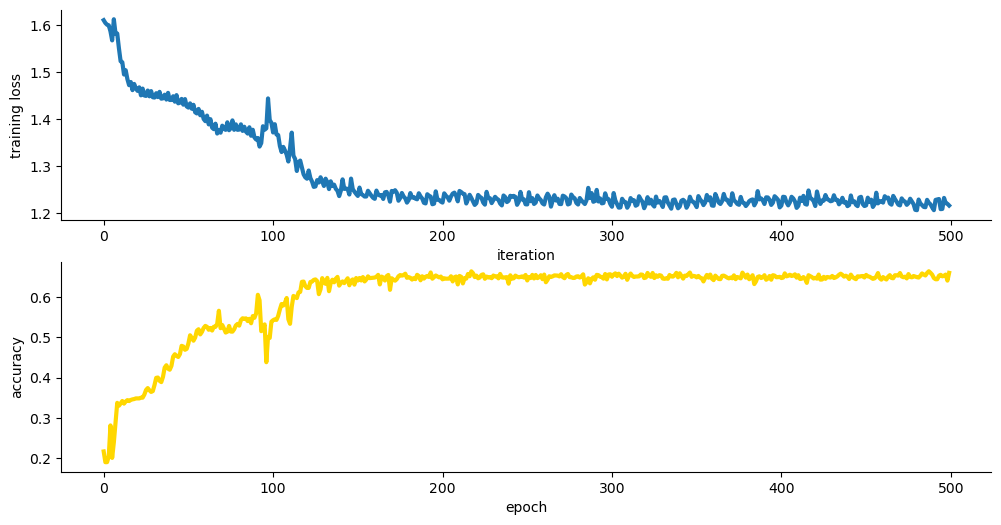

In [37]:
# Import seaborn for prettier plots

import seaborn as sns
# Visualize training loss

plt.figure(figsize = (12, 6))

# Visualize training loss with respect to iterations (1 iteration -> single batch)
plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("iteration")
sns.despine()

# Visualize validation accuracy with respect to epochs
plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("accuracy")
plt.xlabel("epoch")
sns.despine()

In [38]:
# Compute the testing accuracy 

with torch.no_grad():        
    outputs = model(testing_inputs)
    
    correct = (torch.argmax(outputs, dim=1) == torch.argmax(testing_targets,dim=1)).type(torch.FloatTensor).to(device)
    
    test_accuracy = correct.mean().item()
    print('Testing accuracy: {:.4f}'.format(test_accuracy))

Testing accuracy: 0.6656


In [39]:
# Define class names for your problem
class_names = ['Gluon', 'Light quark', 'W boson', 'Z boson', 'Top quark']

# Initialize an empty list to store the accuracy for each class
accuracy_1 = []

# Calculate the accuracy for each class
for i in range(5):
    # Find the indices of the samples in the testing set that belong to class i
    index = np.where(torch.argmax(testing_targets,dim=1).cpu().numpy() == i)[0]
    # Compute the accuracy for class i
    class_correct = (torch.argmax(outputs[index], dim=1) == i).type(torch.FloatTensor).to(device)
    accuracy_1.append(class_correct.mean().item())
    # Print out the accuracy for class i
    print('Accuracy of {}: {:.2f}%'.format(class_names[i], accuracy_1[i] * 100))

# Find the class that the model had the hardest time classifying
hardest_class = class_names[np.argmin(accuracy_1)]
print('The class that the model had the hardest time classifying is: {}'.format(hardest_class))


Accuracy of Gluon: 66.94%
Accuracy of Light quark: 60.00%
Accuracy of W boson: 68.08%
Accuracy of Z boson: 55.78%
Accuracy of Top quark: 81.26%
The class that the model had the hardest time classifying is: Z boson
